<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RANSAC plane

RANdom SAmple Consensus (RANSAC) is an iterative method to make robust nondeterministic estimation of parameters of a mathematical model from a set of data containing outliers.

If is very popular in pointcloud segmentation tasks.The steps of the algorthm:

1. Set up tolerance and the number of iterations
2. Select three random points from the point cloud
3. Find the plane of the randomly selected points
4. Find the inliers, which are closer to the plane than the tolerance
5. If the number of inliers is larger than in any previous solution save the solution as the best sofar
6. Repeat from step 2 if the number of iterations allows

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi, sin, cos
# parameters
tolerance = 0.02
iterations = 1000

Let's generate random points close to a plane and some outliers.

In [51]:
n = 1000 # number of inliers
m = 600  # number of outliers
range = 100.0   # range of coordinates 0-range

# points on a horizontal plane
x = np.random.rand(n + m) * range
y = np.random.rand(n + m) * range
z = np.zeros(n + m)
z[0:n] = np.random.rand(n) * tolerance + range / 2.0
z[n:n+m] = np.random.rand(m) * range
# rotate points to have general plane
alpha = 23.0 / 180.0 * pi   # rotation around x
beta = 38.0 / 180.0 * pi    # rotation around y
r1 = np.array([[1.0, 0.0, 0.0], [0.0, cos(alpha), -sin(alpha)], [0.0, sin(alpha), cos(alpha)]])
r2 = np.array([[cos(beta), 0.0, sin(beta)], [0.0, 1.0, 0.0], [-sin(beta), 0.0, cos(beta)]])
r = r1.dot(r2)
# rotate points
points = np.c_[x, y, z].dot(r)

Let's display the points.

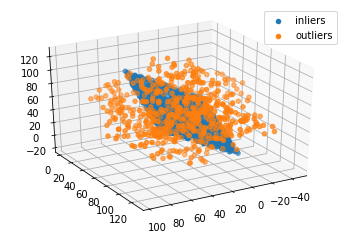

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0:n, 0], points[0:n, 1], points[0:n, 2], label='inliers')
ax.scatter(points[n:n+m, 0], points[n:n+m, 1], points[n:n+m, 2], label='outliers')
ax.legend()
ax.view_init(30, 60) 

Iteration to find RANSAC plane.

In [59]:
if points.shape[1] < 4:
    points = np.c_[points, np.full((n+m, 1), 1)]    # change to homogenouos coord
best_n = 0
best_inliers = np.array([])
for i in np.arange(iterations):
    # select three random points
    l = []  # list of random indices for points
    while len(l) != 3:
        l = list(set(np.random.randint(n+m, size=3))) # remove repeated random integers
    pp = points[l]  # randomly selected points
    # plane equation from the three points
    a = np.linalg.det(pp[:,1:])
    b = -np.linalg.det(pp[:, [0, 2, 3]])
    c = np.linalg.det(pp[:, [0, 1, 3]])
    d = np.linalg.det(pp[:, 0:3])
    plane = np.array([a, b, c, d])
    plane = plane / np.sqrt(plane[0:3].dot(plane[0:3]))   # normal to unit vector
    # select close points
    inliers = points[np.abs(np.dot(points, plane)) < tolerance]
    if inliers.shape[0] > best_n:
        best_n = inliers.shape[0]
        best_inliers = inliers[:,:3].copy()

In [61]:
iterations

1000